# What's in a Headline? Sentiment and Bias in Online Headlines


## Summary
The importance of understanding bias in media cannot be overstated. The divide between political left and right has grown in recent years, due at least in part to the consumption of partisan media fed to users via their social media algorithms. Furthermore, around 75% of news articles shared are passed on [based on their headlines alone](https://www.nature.com/articles/s41562-024-02067-4), without the user ever having read the linked information. As such, this project explores the relationship between bias, reliability, and tone in the headlines of popular media outlets. Using data sources from [NewsAPI](https://newsapi.org/), and bias
and reliability ratings from the [Ad Fontes Media Bias Chart](https://app.adfontesmedia.com/chart/interactive?utm_source=adfontesmedia&utm_medium=website), the goal is to analyze whether headline sentiment tends to correlate with political bias or reliability of media sources.

## Data Sourcing
### NewsAPI
All headlines and accompanying source data came from [NewsAPI](https://newsapi.org/), an HTTP REST API that can be used to search for and retrieve articles from more than 100 news sources from all over the internet.  

### Ad Fontes
Bias scores used in the analysis have been taken from Ad Fontes Media Bias Chart. [Ad Fontes](https://adfontesmedia.com/?utm_source=WEBAPP) is a public benefit corporation based in Colorado whose stated aim is to ["rate all the news to positively transform society"](https://adfontesmedia.com/about-ad-fontes-media/). Using analysts with political views spanning the entirety of the political spectrum, Ad Fontes assigns to each article or outlet a rating for both *bias* and *reliability*. 

Politically neutral sources have a bias score close to 0, while those skewing left and right have negative and positive scores respectively, with the strength of the score correlating to the degree of bias (i.e. the higher the absolute value of the score, the more biased the source is). 

Reliability is rated on scale of 0 to 64 with the highest scores being given to outlets with fact-based reporting and a high degree of effort applied towards neutrality. Toward the middle of the spectrum, media sources have less reliability in their reporting or are a mixture of fact and opinion based articles. And, finally, those sources at the bottom of the scale contain information that is misleading, inaccurate, or fabricated.


## Data Collection
The following outlines the specific functionality of each Python script and the steps taken to arrive at the dataset used in the analysis (`flattened_articles.csv`). Although it was necessary to compile the list of Ad Fontes sources manually, each file following step 2 could be combined into a single script. For the sake of clarity, as well as modularity/reusability, they have been left as separate steps.

1. `fetch_newsapi_sources.py` - Retrieves the full list of news sources from NewsAPI, and saves
them in JSON format to `data/raw/newsapi_sources.json`.
2. `ad_fontes_sources.json` - A JSON-formatted list of news sources with their associated 
bias and reliability scores from Ad Fontes. As Ad Fontes only provides data for their paid tiers, it was necessary to compile this manually based on overlapping sources from NewsAPI.
3. `merge_sources.py` - Merges the sources from NewsAPI with their bias and reliability scores from Ad Fontes and saves them in JSON format to `data/raw/merged_sources.json`
4. `fetch_hl_objects_from_api.py` - Fetches the headline/article objects from NewsAPI and saves them in JSON format to `data/raw/headline_objects.json`. This script can be exceuted multiple times, as the new data is integrated with the existing data, and duplicates are overwritten. All data for this analysis was collected between 10/4/2025 and 10/9/2025 using a cron job set to fetch articles every hour.
5. `flatten_articles.py` - Flattens all article objects into a csv file saved to `data/flattened_articles.csv`.

## Analysis


### Data Preparation

In [51]:
# Necessary imports
import json
import pandas as pd 
import numpy as np 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from matplotlib import pyplot as plt

[nltk_data] Downloading package vader_lexicon to /home/j/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [27]:
# import sources into a dataframe to obtain bias/reliability data
with open ("../data/raw/merged_sources.json", "r") as file:
    sources = json.load(file)
sources_df = pd.DataFrame.from_dict(sources, orient="index")
sources_df.head(3)
    

,id,name,description,url,category,country,reliability,bias
abc news,abc-news,abc news,"your trusted source for breaking news, analysi...",https://abcnews.go.com,general,us,44.60,-3.10
al jazeera english,al-jazeera-english,al jazeera english,"news, analysis from the middle east and worldw...",https://www.aljazeera.com,general,us,41.28,-7.31
associated press,associated-press,associated press,the ap delivers in-depth coverage on the inter...,https://apnews.com/,general,us,44.81,-2.47


In [ ]:
# import the article information into a Pandas dataframe
article_df = pd.read_csv("../data/flattened_articles.csv")
article_df.head(3)

,id,name,author,title,description,url,urlToImage,publishedAt,content
0,cbs-news,CBS News,Matt Richardson,"Here's how much a $30,000 HELOC costs monthly ...","A $30,000 HELOC is inexpensive after the Fed c...",https://www.cbsnews.com/news/how-much-a-30000-...,https://assets1.cbsnewsstatic.com/hub/i/r/2015...,2025-10-03T14:13:09Z,HELOC borrowing costs are declining again now ...
1,fox-news,Fox News,NaN,Diddy sentencing begins as rapper faces up to ...,"The disgraced music mogul Sean ""Diddy"" Combs f...",https://www.foxnews.com/entertainment/diddy-se...,https://static.foxnews.com/foxnews.com/content...,2025-10-03T14:12:57Z,"Sean ""Diddy"" Combs appeared in court Friday, m..."
2,cbs-news,CBS News,CBS News,Vengeful veterinarian eyed in Oregon man's par...,Investigators discover a trail of evidence aft...,https://www.cbsnews.com/video/vengeful-veterin...,https://assets2.cbsnewsstatic.com/hub/i/r/2025...,2025-10-03T14:11:00Z,Copyright ©2025 CBS Interactive Inc. All right...


In [32]:
# merge dataframes
df = pd.merge(sources_df, article_df, on="id")
df.head(3)

,id,name_x,description_x,url_x,category,country,reliability,bias,name_y,author,title,description_y,url_y,urlToImage,publishedAt,content
0,abc-news,abc news,"your trusted source for breaking news, analysi...",https://abcnews.go.com,general,us,44.6,-3.1,ABC News,ROB GILLIES Associated Press,Canadian Prime Minister Mark Carney to meet Tr...,Canadian Prime Minister Mark Carney is to hold...,https://abcnews.go.com/International/wireStory...,https://i.abcnewsfe.com/a/6d778f67-3556-4a35-9...,2025-10-03T13:58:26Z,TORONTO -- TORONTO (AP) Canadian Prime Ministe...
1,abc-news,abc news,"your trusted source for breaking news, analysi...",https://abcnews.go.com,general,us,44.6,-3.1,ABC News,LINDSAY WHITEHURST Associated Press,Supreme Court to consider overturning Hawaii l...,The Supreme Court says it will consider overtu...,https://abcnews.go.com/US/wireStory/supreme-co...,https://i.abcnewsfe.com/a/bad5c649-e480-4f7d-b...,2025-10-03T13:53:11Z,WASHINGTON -- WASHINGTON (AP) The Supreme Cour...
2,abc-news,abc news,"your trusted source for breaking news, analysi...",https://abcnews.go.com,general,us,44.6,-3.1,ABC News,The Associated Press,Early snowfall damages power lines and snarls ...,Early snowfall in the Western Balkans has left...,https://abcnews.go.com/International/wireStory...,https://i.abcnewsfe.com/a/216854b3-335e-46d4-a...,2025-10-03T13:32:47Z,"BELGRADE, Serbia -- BELGRADE, Serbia (AP) Earl..."


In [33]:
# remove unnecessary columns
df = df[["id", "name_x", "category", "reliability", "bias", "author", "title"]]
df.head(3)

,id,name_x,category,reliability,bias,author,title
0,abc-news,abc news,general,44.6,-3.1,ROB GILLIES Associated Press,Canadian Prime Minister Mark Carney to meet Tr...
1,abc-news,abc news,general,44.6,-3.1,LINDSAY WHITEHURST Associated Press,Supreme Court to consider overturning Hawaii l...
2,abc-news,abc news,general,44.6,-3.1,The Associated Press,Early snowfall damages power lines and snarls ...


### General Statistics

In [ ]:
# source information 
source_ids = df["id"].unique()
left_sources = df[df["bias"] < 0]["id"].unique()
right_sources = df[df["bias"] > 0]["id"].unique()
left_headlines = df[df["id"].isin(left_sources)]
right_headlines = df[df["id"].isin(right_sources)]

print(f"Number of unique sources: {len(source_ids)}")
print(f"Number of left-skewing sources: {len(left_sources)}")
print(f"Number of right_skewing sources: {len(right_sources)}")
print(f"\nNumber of headlines per source:")
id_group = df.groupby("id")
print(id_group["id"].count())
print(f"Number of headlines from left-skewing sources: {len(left_headlines)}")
print(f"Number of headlines from right-skewing sources: {len(right_headlines)}")
print(f"\nTotal number of headlines: {len(df)}")

Number of unique sources: 19
Number of left-skewing sources: 16
Number of right_skewing sources: 3

Number of headlines per source:
id
abc-news                     310
al-jazeera-english           173
associated-press              55
bbc-news                     178
bloomberg                     18
breitbart-news               219
business-insider             216
cbs-news                     361
cnn                           66
fox-news                     372
msnbc                         51
nbc-news                     100
newsweek                       2
politico                       2
the-american-conservative      7
the-hill                       8
the-washington-post            5
time                           2
usa-today                    214
Name: id, dtype: int64
Number of headlines from left-skewing sources: 1761
Number of headlines from right-skewing sources: 598

Total number of headlines: 2359


/tmp/ipykernel_30453/4100704819.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


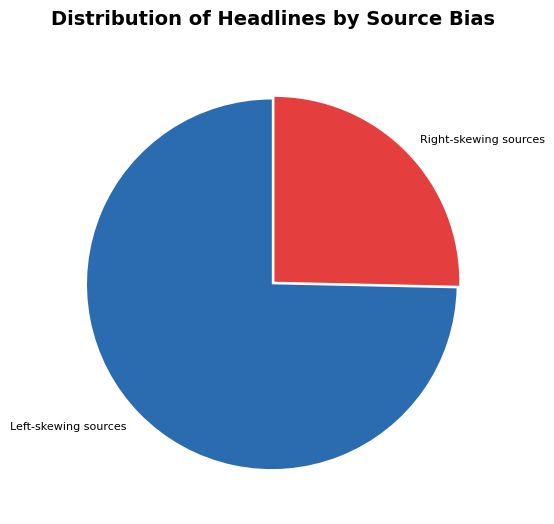

In [ ]:
# Pie chart of headlines by bias
colors = ["#2b6cb0", "#e53e3e"]
labels = ["Left-skewing sources", "Right-skewing sources"]
explode = (0.01, 0.01)
fig, ax = plt.subplots(figsize=(6, 6))


ax.pie(
    [len(left_headlines), len(right_headlines)], 
    colors = colors,
    labels=labels,
    explode=explode,
    startangle=90,
    textprops={"fontsize": 8, "color":"black"})
ax.set_title('Distribution of Headlines by Source Bias', fontsize=14, fontweight='bold', pad=20)

fig.show()